<a href="https://colab.research.google.com/github/mykon23/AI-2020/blob/master/Activities/Activity17.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Early Stopping

In [1]:
!wget -O Baseball.csv https://github.com/mykon23/AI-2020/blob/master/Data/Baseball.csv?raw=True

--2020-11-17 05:50:33--  https://github.com/mykon23/AI-2020/blob/master/Data/Baseball.csv?raw=True
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/mykon23/AI-2020/raw/master/Data/Baseball.csv [following]
--2020-11-17 05:50:34--  https://github.com/mykon23/AI-2020/raw/master/Data/Baseball.csv
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/mykon23/AI-2020/master/Data/Baseball.csv [following]
--2020-11-17 05:50:34--  https://raw.githubusercontent.com/mykon23/AI-2020/master/Data/Baseball.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 20

In [2]:
import pandas as pd
data = pd.read_csv('Baseball.csv')
data.head()

,Team,League,Year,RS,RA,W,OBP,SLG,BA,Playoffs,RankSeason,RankPlayoffs,G,OOBP,OSLG
0,ARI,NL,2012,734,688,81,0.328,0.418,0.259,0,NaN,NaN,162,0.317,0.415
1,ATL,NL,2012,700,600,94,0.320,0.389,0.247,1,4.0,5.0,162,0.306,0.378
2,BAL,AL,2012,712,705,93,0.311,0.417,0.247,1,5.0,4.0,162,0.315,0.403
3,BOS,AL,2012,734,806,69,0.315,0.415,0.260,0,NaN,NaN,162,0.331,0.428
4,CHC,NL,2012,613,759,61,0.302,0.378,0.240,0,NaN,NaN,162,0.335,0.424


In [3]:
##Get the features of interest
features = [ 'OBP', 'SLG', 'BA' ]
output = ['RS']

In [4]:
import numpy as np

years = data['Year'].unique()
val_years = np.random.choice( years, int(0.25 * len(years)), replace = False )
print(val_years)

[1968 1989 1997 1977 1969 1974 2000 2006 1963 1973 1984]


In [5]:
##Establish the Training Set and the Validation Sets

TRAIN = pd.DataFrame()
VALID = pd.DataFrame()

for y in years:
  elem = data[ data['Year'] == y][features + output]
  if y in val_years:
    VALID = pd.concat( [VALID, elem] )
  else:
    TRAIN = pd.concat( [TRAIN, elem] )

##Training Set
TRAIN = TRAIN.to_numpy()

##Validation Set
VALID = VALID.to_numpy()

In [6]:
##Set Copies of numpy arrays
XTRAIN = np.array( TRAIN[:, :-1] )
YTRAIN = TRAIN[:, -1]

XVALID = np.array( VALID[:, :-1] )
YVALID = VALID[:, -1]

In [7]:
##Adjust the Training Data
mean = XTRAIN.mean(axis = 0)
XTRAIN -= mean
std = XTRAIN.std(axis = 0)
XTRAIN /= std

##Adjust the Validation Data
XVALID -= mean
XVALID /= std

Define Evaluation Utilities

In [8]:
import matplotlib.pyplot as plt
from sklearn import metrics

class PlotUtil:
  @staticmethod
  def get_learning_curve(history):
    f, ax = plt.subplots()
    ax.plot(history.history['loss'], '-', label = 'Training', color = 'blue')
    ax.plot(history.history['val_loss'], '--', label = 'Validation', color = 'orange')
    ax.set_ylabel('Loss')
    ax.set_xlabel('epoch')
    ax.set_yscale('log')
    ax.legend()
    return (f, ax)

class RegEvalUtil:
  @staticmethod
  def get_eval_metrics(y_true, y_pred):
    return { 'mse': metrics.mean_squared_error(y_true, y_pred),
            'mae': metrics.mean_absolute_error(y_true, y_pred) }

Define Model Utilities

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

class ModelUtil:
  @staticmethod
  def get_model(input):
    model = Sequential()
    model.add( Dense(18, input_dim = input, activation='relu'))
    model.add( Dense(6, activation='relu'))
    model.add( Dense(3, activation = 'relu' ))
    model.add( Dense(1, activation = 'relu' ))
    return model

DEFAULT_EPOCHS = 512

##Define the callbacks
model_callbacks = { 'cp': ModelCheckpoint(filepath = 'stop_nn.hdf5', monitor='val_loss', save_best_only = True, save_weights_only = True, verbose = 0), 
             'es': EarlyStopping(monitor='val_loss', mode='min', patience=52, verbose=0) }

##Regression Model with Early Stopping

In [10]:
stop_nn = ModelUtil.get_model(len(features))
##Save the initial weights
stop_nn.save_weights('init_weights.hdf5')
stop_nn.compile(loss = 'mae', optimizer = 'rmsprop', metrics = ['mae'])
stop_nn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 18)                72        
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 114       
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 21        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 4         
Total params: 211
Trainable params: 211
Non-trainable params: 0
_________________________________________________________________


In [11]:
import time

##Train the Model
start_stop = time.time()
history_stop = stop_nn.fit( XTRAIN, YTRAIN,
                      validation_data = (XVALID, YVALID),
                      epochs = DEFAULT_EPOCHS,
                      callbacks = model_callbacks.values(),
                      verbose = 0)
end_stop = time.time()

In [12]:
print(f'Epochs: {len(history_stop.history["loss"])}')
print(f'Time (s): {end_stop - start_stop:.2f}')

Epochs: 305
Time (s): 15.95


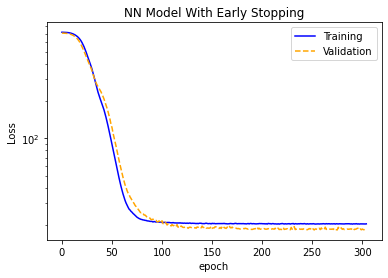

In [13]:
##View the Learning Curves
figs = PlotUtil.get_learning_curve(history_stop)
figs[1].set_title('NN Model With Early Stopping')
figs[0].show()

In [14]:
##Display the Loss metrics on the final model with early stopping
train_pred = stop_nn.predict(XTRAIN)
valid_pred = stop_nn.predict(XVALID)

stop_final = pd.DataFrame.from_dict({ 'train': RegEvalUtil.get_eval_metrics(YTRAIN, train_pred),
              'valid': RegEvalUtil.get_eval_metrics(YVALID, valid_pred)})
stop_final.head().T

,mse,mae
train,662.028920,20.626894
valid,548.104808,18.805819


In [15]:
##Acquire the weights pertaining to the best model from the checkpoint
comp_model = ModelUtil.get_model(len(features))
comp_model.load_weights('stop_nn.hdf5')

##Get the predictions of the data with the best model
train_pred = comp_model.predict(XTRAIN)
valid_pred = comp_model.predict(XVALID)

stop_best = pd.DataFrame.from_dict({ 'train': RegEvalUtil.get_eval_metrics(YTRAIN, train_pred),
              'valid': RegEvalUtil.get_eval_metrics(YVALID, valid_pred)})
stop_best.head().T

,mse,mae
train,656.671282,20.412695
valid,527.779551,18.271230


##Regression Model without Early Stopping

In [16]:
##Load the initial weights
runs_nn = ModelUtil.get_model(len(features))
runs_nn.load_weights('init_weights.hdf5')
runs_nn.compile(loss = 'mae', optimizer = 'rmsprop', metrics = ['mae'] )
runs_nn.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 18)                72        
_________________________________________________________________
dense_9 (Dense)              (None, 6)                 114       
_________________________________________________________________
dense_10 (Dense)             (None, 3)                 21        
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 4         
Total params: 211
Trainable params: 211
Non-trainable params: 0
_________________________________________________________________


In [17]:
import time

##Train the Model
start_runs = time.time()
history_nn = runs_nn.fit( XTRAIN, YTRAIN,
                      validation_data = (XVALID, YVALID),
                      epochs = DEFAULT_EPOCHS,
                      callbacks = [ model_callbacks['cp'] ],
                      verbose = 0)
end_runs = time.time()

In [18]:
print(f'Epochs: {len(history_nn.history["loss"])}')
print(f'Time (s): {end_runs - start_runs:.2f}')

Epochs: 512
Time (s): 24.26


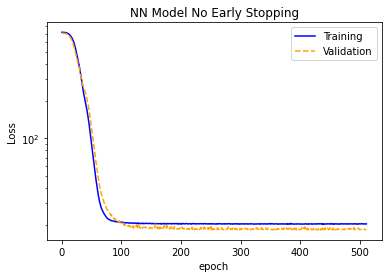

In [19]:
##View the Learning Curves
figs = PlotUtil.get_learning_curve(history_nn)
figs[1].set_title('NN Model No Early Stopping')
figs[0].show()

In [20]:
##Get the Predictions on Training and Validation
train_pred = runs_nn.predict(XTRAIN)
valid_pred = runs_nn.predict(XVALID)

nn_metrics = pd.DataFrame.from_dict({ 'train': RegEvalUtil.get_eval_metrics(YTRAIN, train_pred),
              'valid': RegEvalUtil.get_eval_metrics(YVALID, valid_pred)})
nn_metrics.head().T

,mse,mae
train,658.581274,20.267613
valid,541.047092,18.493327


In [21]:
##Acquire the weights pertaining to the best model from the checkpoint
comp_model = ModelUtil.get_model(len(features))
comp_model.load_weights('stop_nn.hdf5')

##Get the predictions of the data with the best model
train_pred = comp_model.predict(XTRAIN)
valid_pred = comp_model.predict(XVALID)

cp_best = pd.DataFrame.from_dict({ 'train': RegEvalUtil.get_eval_metrics(YTRAIN, train_pred),
              'valid': RegEvalUtil.get_eval_metrics(YVALID, valid_pred)})
cp_best.head().T

,mse,mae
train,656.671282,20.412695
valid,527.779551,18.271230


Early stopping permits the model to cease training once a defined loss no longer improves beyond the model's patience.  The model is to train for 512 epochs if no early stopping callbacks are applied.  An early stopping callback with a patience of 48 epochs was applied to the model's training for comparison.  The training with early stopping terminates at 305 epochs compared to the training of 512 epochs.  The early stopping permits the model to cease training at 60% of the defined epochs.  The time required for each of these trainings in terms of seconds is 15.95 seconds for early stopping versus 24.26 seconds for all epochs.  The difference in time seems minimal, but the difference in epochs suggests that early stopping becomes more beneficial for training with greater epoch times.

Four sets of trainable parameters were identified: the weights acquired from training for all epochs, the weights acquired with model checkpointing for all epochs, the weights acquired at the end of early stopping, and the weights acquired with model checkpointing and early stopping.  The initial weights for the first isntance of the model were saved and loaded onto each model prior to training to ensure a fair comparison.  Recall that the initial weights for a model are initialized randomly and it would be unfair to compare the results from one instance of a model against another instance if the initial weights differed.  It was found that the model checkpointing weights between the early stopping and the total training are the same to reduce the collection to three sets.  The weights from model checkpointing yield the minimal MAE of 18.27 on the validation set compared to the 18.49 and 18.81 of the total training and early stopping respectively.  The minimal loss on the validation set does not transfer to the training set as the other weights performed better on the training set as expected.  The training process consists of optimizing on the training loss and it is expected that the loss on the training set decreases with additional epochs.  The model checkpointing serves as a way to acquire the best set of weights prior to overfitting.